In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [105]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict
import os
import argparse
import atari_py
import torch

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [123]:
np.set_printoptions(precision=5)

In [6]:
api = wandb.Api()

In [7]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [8]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


_StoreAction(option_strings=['--heap-debug-file'], dest='heap_debug_file', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Load a sample run, model, try to plot filters

In [149]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, cache=LOADED_MODEL_CACHE):
    if run not in cache:
        checkpoint_path = download_checkpoint(run)
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[run] = dqn, env
        
    return cache[run]

# Implement some analysis functions

In [153]:
def first_layer_filter_sums(model, absolute=True):
    weight = model.online_net.convs[0].weight.detach()
    if absolute:
        weight = weight.abs()
        
    return weight.sum(3).sum(2).cpu().numpy()


def first_layer_per_frame(model, absolute=True, channels_per_frame=9, ratio=True):
    first_layer = first_layer_filter_sums(model, absolute)
    per_frame_sums = np.array([first_layer[:, i * channels_per_frame:(i + 1) * channels_per_frame].sum() for i in range(4)])
    if ratio:
        return per_frame_sums / np.max(per_frame_sums)
    
    return per_frame_sums


def first_layer_per_channel(model, absolute=True, channels_per_frame=9, ratio=True):
    first_layer = first_layer_filter_sums(model, absolute)
    per_channel_sums = [first_layer[:, list(np.arange(4) * (i + 1))].sum() for i in range(channels_per_frame)]
    if ratio:
        return per_channel_sums / np.max(per_channel_sums)
    return per_channel_sums


def find_top_correlations(model, absolute=False, top_k=5, use_all_frames=False, channels_per_frame=9):
    first_layer = first_layer_filter_sums(model, absolute)
    
    if use_all_frames:
        cols = [first_layer[:, i * channels_per_frame:(i + 1) * channels_per_frame] for i in range(4)]
        data = np.vstack(cols)
        
    else:
        data = first_layer[:, -channels_per_frame:]
        
    df = pd.DataFrame(data)
    corrs = np.array(df.corr())
    # take only elements above the diagonal, sort by absolute correlation coefficient, select top_k
    top_corrs = sorted([(corrs[x], x) for x in zip(*np.triu_indices(corrs.shape[0], k=1))], 
                       key=lambda t: abs(t[0]), reverse=True)[:top_k]
    return top_corrs


def masker_def_indices_to_names(env):
    return [[key for key in ALL_MASKERS if ALL_MASKERS[key] == masker_def][0] for masker_def in env.masker.masker_definitions]


def prettify(correlation_results):
    return [(np.round(t[0], 5), t[1]) for t in correlation_results]


def compute_filter_statistics(run, channels_per_frame=9, top_k=5):
    model, env = load_model_from_run(run)
    
    print(f'First layer absolute frame ratio:\n{first_layer_per_frame(model, channels_per_frame=channels_per_frame)}')
    print(f'First layer frame sums:\n{first_layer_per_frame(model, absolute=False, ratio=False, channels_per_frame=channels_per_frame)}')
    print()
    print(f'First layer absolute channel ratios:\n{first_layer_per_channel(model, channels_per_frame=channels_per_frame)}')
    print(f'First layer channel sums:\n{first_layer_per_channel(model,  absolute=False, ratio=False, channels_per_frame=channels_per_frame)}')
    print()
    print(f'First layer last frame top channel correlations:\n{prettify(find_top_correlations(model, top_k=top_k, channels_per_frame=channels_per_frame))}')
    print(f'First layer all frames top channel correlations:\n{prettify(find_top_correlations(model, top_k=top_k, use_all_frames=True, channels_per_frame=channels_per_frame))}')
    print(f'First layer absolute last frame top channel correlations:\n{prettify(find_top_correlations(model, absolute=True, top_k=top_k, channels_per_frame=channels_per_frame))}')
    print()
    
    
def average_correlations_over_all_runs(runs, absolute=False, use_all_frames=False, channels_per_frame=9):
    correlations = []
    for run in runs:
        model, env = load_model_from_run(run)
        first_layer = first_layer_filter_sums(model, absolute)
    
        if use_all_frames:
            cols = [first_layer[:, i * channels_per_frame:(i + 1) * channels_per_frame] for i in range(4)]
            data = np.vstack(cols)

        else:
            data = first_layer[:, -channels_per_frame:]

        df = pd.DataFrame(data)
        correlations.append(np.array(df.corr()))
    
    all_corrs = np.array(correlations)
    return np.array(correlations).mean(0), all_corrs.std(0)

# Trying this on all runs in a project

In [146]:
for rep_run in api.runs('augmented-frostbite/masks-and-pixels-replication'):
    print(rep_run.config['seed'])
    compute_filter_statistics(rep_run)
    

309
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-309-10000000.pth
First layer absolute frame ratio:
[0.66001 0.5965  0.64668 1.     ]
First layer frame sums:
[-223.10484 -170.89482  -68.50803  -75.56364]

First layer absolute channel ratios:
[0.92371 0.82163 0.7772  0.69871 0.91221 0.79505 0.95452 1.      0.94269]
First layer channel sums:
[-52.08837, -84.69349, -69.920654, -69.84119, -40.565163, -44.896927, -137.11212, -127.862816, -23.047718]

First layer last frame top channel correlations:
[(-0.47051, (3, 8)), (0.444, (5, 6)), (-0.41673, (1, 7)), (0.40942, (5, 8)), (-0.38067, (1, 5))]
First layer all frames top channel correlations:
[(0.60091, (5, 6)), (0.29863, (0, 7)), (-0.2672, (1, 5)), (-0.25384, (3, 8)), (-0.2538, (0, 4))]
First layer absolute last frame top channel correlations:
[(0.68389, (5, 6)), (0.37177, (5, 7)), (-0.35244, (0, 3)), (-0.33389, (1, 7)), (0.33071, (0, 2))]

308
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-

Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-300-10000000.pth
First layer absolute frame ratio:
[0.66605 0.62802 0.65344 1.     ]
First layer frame sums:
[-226.72372 -215.11328   -3.16011  -25.78526]

First layer absolute channel ratios:
[0.94651 0.83171 0.73962 0.64616 0.91178 0.73974 0.88995 1.      0.86777]
First layer channel sums:
[-96.08168, -113.672264, -93.27403, -35.74564, -65.88256, -60.56411, -161.88898, -92.420425, -35.34289]

First layer last frame top channel correlations:
[(-0.56404, (7, 8)), (-0.55483, (0, 8)), (0.49747, (1, 8)), (0.46087, (2, 6)), (-0.4546, (0, 4))]
First layer all frames top channel correlations:
[(0.44621, (5, 6)), (0.40388, (0, 7)), (-0.37675, (0, 4)), (-0.37474, (0, 3)), (0.37145, (1, 8))]
First layer absolute last frame top channel correlations:
[(0.49388, (0, 6)), (0.4026, (5, 6)), (-0.38582, (2, 8)), (-0.32098, (1, 6)), (0.31542, (3, 5))]



In [147]:
print(masker_def_indices_to_names(env))

['player', 'bad_animal', 'land', 'bear', 'unvisited_floe', 'visited_floe', 'good_animal', 'igloo']


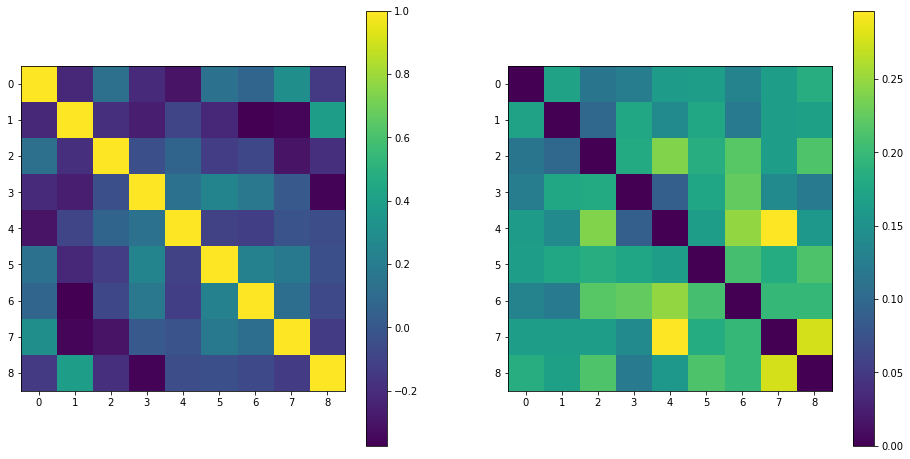

In [161]:
mean, std = average_correlations_over_all_runs(api.runs('augmented-frostbite/masks-and-pixels-replication'))

plt.figure(figsize=(16, 8))
mean_ax = plt.subplot(1, 2, 1)
ax_im = mean_ax.imshow(mean)
plt.colorbar(ax_im, ax=mean_ax)

std_ax = plt.subplot(1, 2, 2)
ax_im = std_ax.imshow(std)
plt.colorbar(ax_im, ax=std_ax)

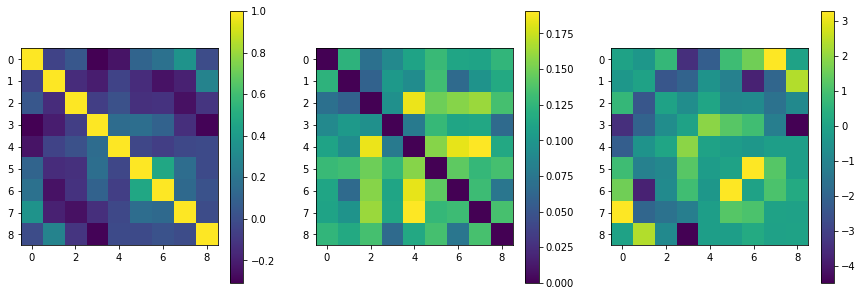

In [165]:
mean, std = average_correlations_over_all_runs(api.runs('augmented-frostbite/masks-and-pixels-replication'), use_all_frames=True)

plt.figure(figsize=(15, 5))
mean_ax = plt.subplot(1, 3, 1)
ax_im = mean_ax.imshow(mean)
plt.colorbar(ax_im, ax=mean_ax)

std_ax = plt.subplot(1, 3, 2)
ax_im = std_ax.imshow(std)
plt.colorbar(ax_im, ax=std_ax)

np.fill_diagonal(mean, 0)
np.fill_diagonal(std, 1)

ratio_ax = plt.subplot(1, 3, 3)
ax_im = ratio_ax.imshow(mean / std)
plt.colorbar(ax_im, ax=ratio_ax)

# Let's try the other set of masks and pixels

In [166]:
for rep_run in api.runs('augmented-frostbite/masks-and-pixels-fixed-resume'):
    print(rep_run.config['seed'])
    compute_filter_statistics(rep_run)
    

309
Loading pretrained model: /scratch/gd1279/masks-and-pixels-309-6500000.pth
First layer absolute frame ratio:
[0.64969 0.57947 0.66044 1.     ]
First layer frame sums:
[-135.52032 -111.99203    7.38423   19.28746]

First layer absolute channel ratios:
[1.      0.83276 0.76596 0.71108 0.93893 0.78655 0.83539 0.92407 0.90015]
First layer channel sums:
[-43.46799, -62.52684, -60.849014, -43.463028, -47.551163, -40.309425, -75.868805, -63.36576, -22.89624]

First layer last frame top channel correlations:
[(0.47774, (0, 2)), (-0.4751, (0, 4)), (-0.44576, (4, 8)), (0.41593, (1, 8)), (-0.40935, (3, 8))]
First layer all frames top channel correlations:
[(0.39729, (5, 6)), (0.31216, (0, 2)), (-0.30373, (0, 4)), (-0.30178, (2, 7)), (-0.28271, (3, 8))]
First layer absolute last frame top channel correlations:
[(0.56895, (5, 7)), (0.53477, (0, 2)), (-0.32111, (6, 7)), (0.30946, (1, 4)), (0.30565, (2, 7))]

308
Loading pretrained model: /scratch/gd1279/masks-and-pixels-308-9900000.pth
First lay

Loading pretrained model: /scratch/gd1279/masks-and-pixels-300-8300000.pth
First layer absolute frame ratio:
[0.66797 0.61295 0.65305 1.     ]
First layer frame sums:
[-203.44249 -197.00604  -40.02516  -19.73112]

First layer absolute channel ratios:
[0.97992 0.85128 0.75987 0.68033 0.9363  0.75562 0.93547 1.      0.90985]
First layer channel sums:
[-86.51997, -99.73883, -80.32704, -31.726664, -76.203865, -50.65677, -120.77095, -80.30168, -21.551199]

First layer last frame top channel correlations:
[(-0.54933, (1, 4)), (0.53846, (1, 8)), (-0.51735, (0, 3)), (0.4294, (4, 7)), (-0.41028, (3, 7))]
First layer all frames top channel correlations:
[(0.39558, (1, 8)), (0.37712, (5, 6)), (-0.36486, (0, 3)), (-0.35445, (1, 4)), (0.32462, (4, 7))]
First layer absolute last frame top channel correlations:
[(0.60332, (5, 6)), (0.44937, (2, 7)), (-0.37376, (1, 7)), (-0.3514, (4, 6)), (0.34015, (0, 5))]



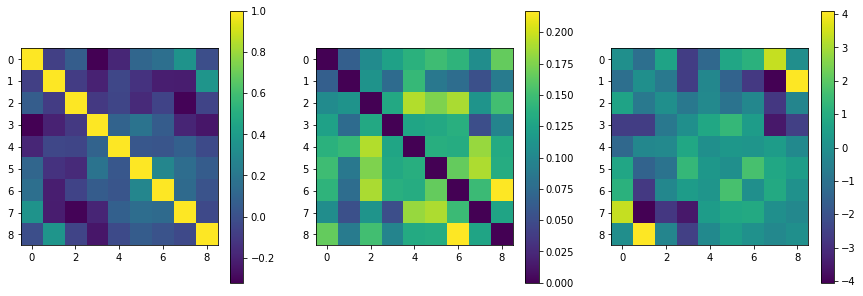

In [167]:
mean, std = average_correlations_over_all_runs(api.runs('augmented-frostbite/masks-and-pixels-fixed-resume'), use_all_frames=True)

plt.figure(figsize=(15, 5))
mean_ax = plt.subplot(1, 3, 1)
ax_im = mean_ax.imshow(mean)
plt.colorbar(ax_im, ax=mean_ax)

std_ax = plt.subplot(1, 3, 2)
ax_im = std_ax.imshow(std)
plt.colorbar(ax_im, ax=std_ax)

np.fill_diagonal(mean, 0)
np.fill_diagonal(std, 1)

ratio_ax = plt.subplot(1, 3, 3)
ax_im = ratio_ax.imshow(mean / std)
plt.colorbar(ax_im, ax=ratio_ax)

# And for the masks only

In [168]:
for rep_run in api.runs('augmented-frostbite/masks-only'):
    print(rep_run.config['seed'])
    compute_filter_statistics(rep_run, channels_per_frame=8)
    

302
Loading pretrained model: /scratch/gd1279/masks-only-302-10000000.pth
First layer absolute frame ratio:
[0.63834 0.58108 0.64602 1.     ]
First layer frame sums:
[-222.5641  -195.01385  -39.85182  -40.85409]

First layer absolute channel ratios:
[0.56312 0.65718 0.68847 0.64889 0.5293  0.63551 0.71948 1.     ]
First layer channel sums:
[-87.19482, -138.81033, -163.60811, -67.55387, -49.662132, -118.76566, -77.99961, -39.942398]

First layer last frame top channel correlations:
[(0.62417, (0, 7)), (-0.59323, (0, 5)), (-0.59082, (2, 7)), (-0.56654, (0, 2)), (-0.49811, (5, 7))]
First layer all frames top channel correlations:
[(-0.54007, (2, 7)), (0.41949, (0, 7)), (0.41734, (4, 5)), (-0.40992, (0, 5)), (-0.32695, (0, 2))]
First layer absolute last frame top channel correlations:
[(0.4173, (1, 6)), (-0.37359, (1, 2)), (-0.36682, (6, 7)), (0.36205, (0, 7)), (0.31875, (4, 6))]

301
Loading pretrained model: /scratch/gd1279/masks-only-301-10000000.pth
First layer absolute frame ratio:
[0

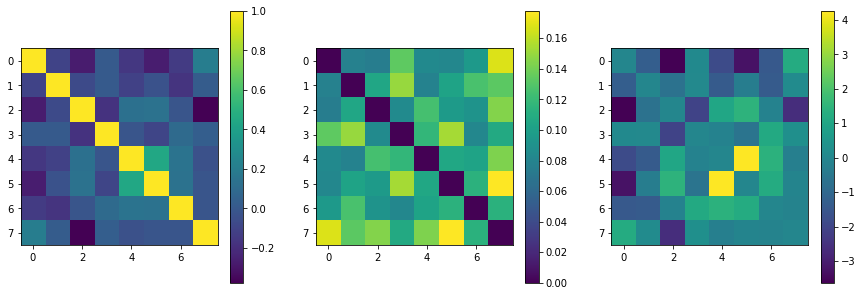

In [170]:
mean, std = average_correlations_over_all_runs(api.runs('augmented-frostbite/masks-only'), use_all_frames=True, channels_per_frame=8)

plt.figure(figsize=(15, 5))
mean_ax = plt.subplot(1, 3, 1)
ax_im = mean_ax.imshow(mean)
plt.colorbar(ax_im, ax=mean_ax)

std_ax = plt.subplot(1, 3, 2)
ax_im = std_ax.imshow(std)
plt.colorbar(ax_im, ax=std_ax)

np.fill_diagonal(mean, 0)
np.fill_diagonal(std, 1)

ratio_ax = plt.subplot(1, 3, 3)
ax_im = ratio_ax.imshow(mean / std)
plt.colorbar(ax_im, ax=ratio_ax)

# Scratch work

In [10]:
run = api.run('augmented-frostbite/masks-and-pixels-fixed-resume/runs/d75ebvh9')

In [11]:
checkpoint_path = download_checkpoint(run)
print(checkpoint_path)
args = setup_args(run)
args.model = checkpoint_path

env = make_env(args)
dqn = Agent(args, env)

/scratch/gd1279/masks-and-pixels-308-9900000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-308-9900000.pth


In [52]:
first_layer_raw_filter_sums = dqn.online_net.convs[0].weight.detach().sum(3).sum(2).cpu().numpy()

In [14]:
first_layer_filter_sums = dqn.online_net.convs[0].weight.detach().abs().sum(3).sum(2).cpu().numpy()
first_layer_filter_sums.shape

(32, 36)

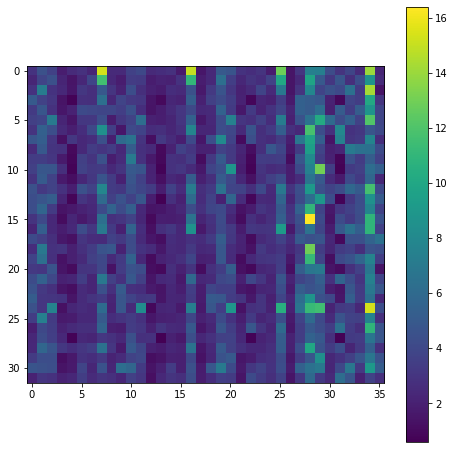

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(first_layer_filter_sums)
plt.colorbar()

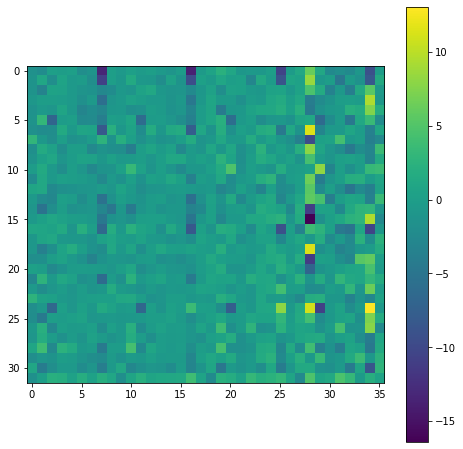

In [71]:
plt.figure(figsize=(8, 8))
plt.imshow(first_layer_raw_filter_sums)
plt.colorbar()

(128, 9)


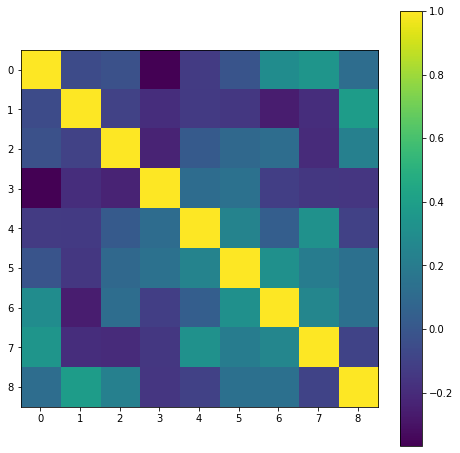

In [82]:
cols = [first_layer_raw_filter_sums[:, i * 9:(i + 1) * 9] for i in range(4)]
st = np.vstack(cols)
print(st.shape)

df = pd.DataFrame(st)
col_corrs = df.corr()

plt.figure(figsize=(8, 8))
plt.imshow(col_corrs)
plt.colorbar()

In [83]:
corrs




,0,1,2,3,4,5,6,7,8
0,1.000000,-0.148964,-0.061409,-0.277001,-0.061195,0.052153,0.265897,0.392446,0.247002
1,-0.148964,1.000000,-0.183954,-0.254425,-0.263269,-0.268112,-0.576618,-0.368151,0.420556
2,-0.061409,-0.183954,1.000000,-0.318326,-0.007143,-0.017639,0.106263,-0.354844,0.424329
3,-0.277001,-0.254425,-0.318326,1.000000,0.137639,0.254005,-0.048909,0.118367,-0.440125
4,-0.061195,-0.263269,-0.007143,0.137639,1.000000,0.366262,-0.024151,0.433127,-0.263112
5,0.052153,-0.268112,-0.017639,0.254005,0.366262,1.000000,0.141034,0.325038,0.019157
6,0.265897,-0.576618,0.106263,-0.048909,-0.024151,0.141034,1.000000,0.222414,-0.100822
7,0.392446,-0.368151,-0.354844,0.118367,0.433127,0.325038,0.222414,1.000000,-0.333958
8,0.247002,0.420556,0.424329,-0.440125,-0.263112,0.019157,-0.100822,-0.333958,1.000000


In [68]:
per_frame_sums = [first_layer_filter_sums[:, i * 9:(i + 1) * 9].sum() for i in range(4)]
per_frame_sums

[951.922, 856.9667, 931.6063, 1407.2622]

In [17]:
per_channel_sums = [first_layer_filter_sums[:, list(np.arange(4) * (i + 1))].sum() for i in range(9)]
per_channel_sums

[443.6662,
 379.83594,
 369.42993,
 317.04797,
 421.5912,
 361.6449,
 431.22705,
 460.71124,
 447.76505]

<BarContainer object of 9 artists>

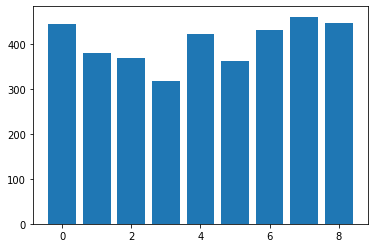

In [28]:
plt.bar(np.arange(len(Out[17])), Out[17])

In [29]:
last_frame_per_channel_sums = [first_layer_filter_sums[-9:, list(np.arange(4) * (i + 1))].sum() for i in range(9)]
last_frame_per_channel_sums

[125.27624,
 108.34224,
 101.75553,
 86.10741,
 110.91457,
 100.024445,
 111.215385,
 118.41924,
 129.34799]

<BarContainer object of 9 artists>

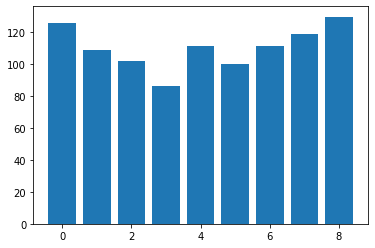

In [30]:
plt.bar(np.arange(len(last_frame_per_channel_sums)), last_frame_per_channel_sums)

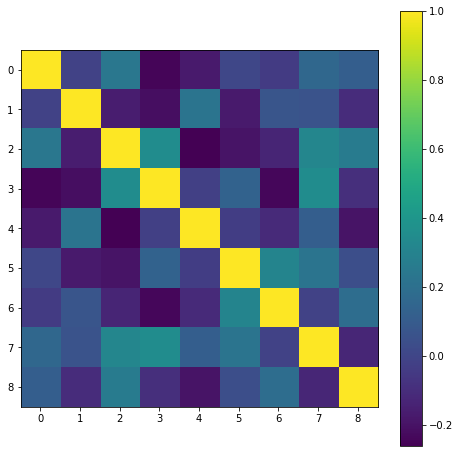

In [51]:
df = pd.DataFrame(first_layer_filter_sums[:, -9:])
corrs = df.corr()

plt.figure(figsize=(8, 8))
plt.imshow(corrs)
plt.colorbar()

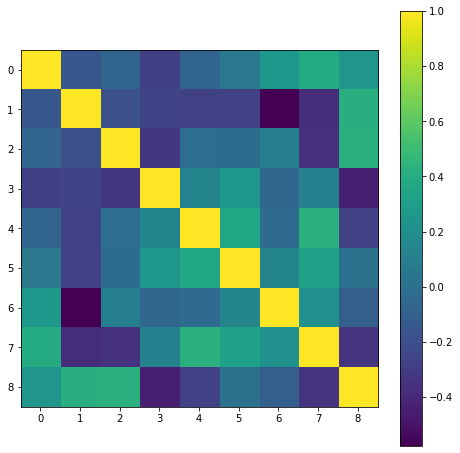

In [72]:
df = pd.DataFrame(first_layer_raw_filter_sums[:, -9:])
corrs = df.corr()

plt.figure(figsize=(8, 8))
plt.imshow(corrs)
plt.colorbar()

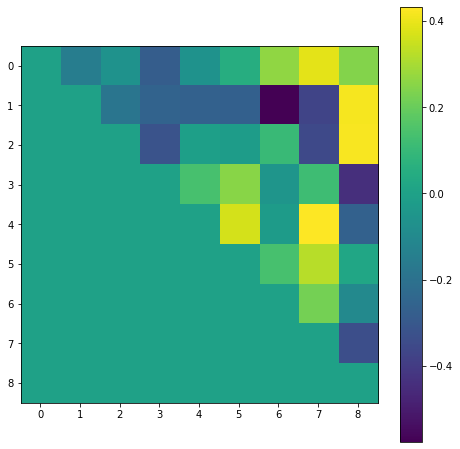

In [77]:
c = np.array(corrs)
diag = np.triu(c, k=1)

plt.figure(figsize=(8, 8))
plt.imshow(diag)
plt.colorbar()

In [102]:
top_k = 5
sorted([(c[x], x) for x in zip(*np.triu_indices(c.shape[0], k=1))], key=lambda t: abs(t[0]), reverse=True)[:top_k]

[(-0.5766175367011075, (1, 6)),
 (-0.4401252733759886, (3, 8)),
 (0.4331270255838787, (4, 7)),
 (0.42432949056608615, (2, 8)),
 (0.42055559030498363, (1, 8))]

In [19]:
second_run = api.run('augmented-frostbite/masks-and-pixels-replication/runs/grh1bzvv')
second_checkpoint_path = download_checkpoint(second_run)
print(second_checkpoint_path)
second_args = setup_args(second_run)
second_args.model = second_checkpoint_path

second_env = make_env(second_args)
second_dqn = Agent(second_args, second_env)

/scratch/gd1279/masks-and-pixels-replication-306-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-306-10000000.pth


In [20]:
second_model_first_layer_filter_sums = dqn.online_net.convs[0].weight.detach().abs().sum(3).sum(2).cpu().numpy()
second_model_first_layer_filter_sums.shape

(32, 36)

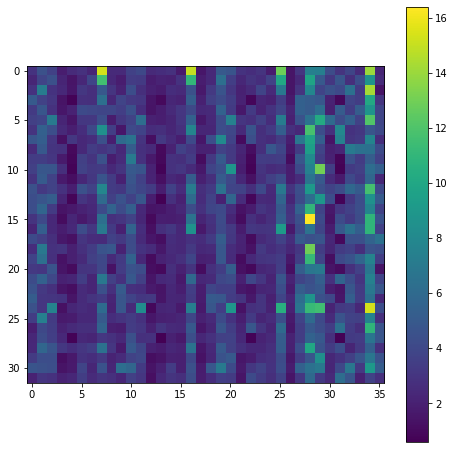

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(second_model_first_layer_filter_sums)
plt.colorbar()

In [24]:
per_frame_sums = [second_model_first_layer_filter_sums[:, i * 9:(i + 1) * 9].sum() for i in range(4)]
per_frame_sums

[951.922, 856.9667, 931.6063, 1407.2622]

In [25]:
per_channel_sums = [second_model_first_layer_filter_sums[:, list(np.arange(4) * (i + 1))].sum() for i in range(9)]
per_channel_sums

[443.6662,
 379.83594,
 369.42993,
 317.04797,
 421.5912,
 361.6449,
 431.22705,
 460.71124,
 447.76505]

In [45]:
'history_length' in args

True

In [55]:
args.__setattr__('history_length', run.config['history_length'])

In [56]:
args.__getattribute__('history_length')

4

In [104]:
env.masker.masker_definitions

[MaskerDefinition(filter_colors=((162, 98, 33), (162, 162, 42), (198, 108, 58), (142, 142, 142)), row_range=(35, 55), col_range=(112, 144), range_whitelist=False),
 MaskerDefinition(filter_colors=((132, 144, 252), (213, 130, 74), (210, 210, 64)), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 MaskerDefinition(filter_colors=((192, 192, 192), (74, 74, 74)), row_range=(42, 78), col_range=(0, 160), range_whitelist=True),
 MaskerDefinition(filter_colors=((111, 111, 111), (214, 214, 214)), row_range=(0, 78), col_range=(0, 160), range_whitelist=True),
 MaskerDefinition(filter_colors=((214, 214, 214),), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 MaskerDefinition(filter_colors=((84, 138, 210),), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 MaskerDefinition(filter_colors=((111, 210, 111),), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 MaskerDefinition(filter_colors=((142, 142, 142),), row_range=(35, 55), col_range=(1

In [106]:
ALL_MASKERS

{'player': MaskerDefinition(filter_colors=((162, 98, 33), (162, 162, 42), (198, 108, 58), (142, 142, 142)), row_range=(35, 55), col_range=(112, 144), range_whitelist=False),
 'unvisited_floe': MaskerDefinition(filter_colors=((214, 214, 214),), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 'visited_floe': MaskerDefinition(filter_colors=((84, 138, 210),), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 'land': MaskerDefinition(filter_colors=((192, 192, 192), (74, 74, 74)), row_range=(42, 78), col_range=(0, 160), range_whitelist=True),
 'bad_animal': MaskerDefinition(filter_colors=((132, 144, 252), (213, 130, 74), (210, 210, 64)), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 'good_animal': MaskerDefinition(filter_colors=((111, 210, 111),), row_range=(78, 185), col_range=(0, 160), range_whitelist=True),
 'bear': MaskerDefinition(filter_colors=((111, 111, 111), (214, 214, 214)), row_range=(0, 78), col_range=(0, 160), range_whitelist=Tr

['player',
 'bad_animal',
 'land',
 'bear',
 'unvisited_floe',
 'visited_floe',
 'good_animal',
 'igloo']